<a href="https://colab.research.google.com/github/Yifei-Lexie-Li/Credit-Fraud-Detection/blob/main/ColabSparkIntroductionStudentVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Java (required for Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Apache Spark 3.5.0 with Hadoop 3
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Install required Python packages
!pip install -q findspark
!pip install pyspark==3.5.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d4302626854a0ffd6e614c38395554b5c26c91a07b457a4221704050b17ac166
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


**Why Spark requires Java?**
1.   Java Virtual Machine (JVM) Dependence: Spark runs on the Java Virtual Machine (JVM), which allows it to work across different operating systems.
2. Language Interoperability: Because it runs on the JVM, Spark can easily work with Java and Scala — the languages it was originally written in.
3. Performance: The JVM helps manage memory efficiently, which is important when Spark is processing large datasets.
4. Ecosystem Compatibility: Spark can take advantage of the large Java ecosystem — including tools and libraries — to make data processing more powerful.


In [ ]:
import os

# Automatically detect Java version path (Java 8 or 11, whichever is installed)
java_8_path = "/usr/lib/jvm/java-8-openjdk-amd64"
java_11_path = "/usr/lib/jvm/java-11-openjdk-amd64"

# Use whichever Java version is available
if os.path.exists(java_8_path):
    os.environ["JAVA_HOME"] = java_8_path
elif os.path.exists(java_11_path):
    os.environ["JAVA_HOME"] = java_11_path
else:
    raise EnvironmentError("No compatible Java version found.")

# Update to Spark 3.5.0 path
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
# Initialize Spark with findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, to_date, to_timestamp
from pyspark.sql.types import *

# Optional: useful utilities
from datetime import datetime, date, timedelta
import random

In [ ]:
# Initialize a SparkSession (entry point to Spark functionality)
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("My First Spark App") \
    .master("local[*]") \
    .getOrCreate()

# Optional: Check the Spark version
print("Spark version:", spark.version)

In [ ]:
# View all Spark configuration settings
for item in spark.sparkContext.getConf().getAll():
    print(f"{item[0]} = {item[1]}")

### 🔍 Key Spark Configuration Settings Explained

---



| Config Key | Meaning | Teaching Interpretation |
|------------|---------|--------------------------|
| `spark.app.name = My First Spark App` | Name of your application | Useful for identifying jobs in logs or Spark UI |
| `spark.master = local[*]` | Run Spark locally using all available CPU cores | `*` means use all cores — perfect for Colab |
| `spark.app.id = local-...` | Unique ID for the Spark application run | Changes each time you restart the app |
| `spark.driver.host` | Hostname of the Spark driver | Automatically set by Colab; not user-controlled |
| `spark.driver.port` | Port for driver communication | Also auto-assigned; not usually changed |
| `spark.submit.deployMode = client` | Mode for job submission | Always `client` in Colab/local runs |
| `spark.rdd.compress = True` | RDDs are compressed in memory | Helps save RAM; good performance default |
| `spark.serializer.objectStreamReset = 100` | Frequency of serialization stream resets | Tuning option, can be ignored for now |
| `spark.submit.pyFiles = ` | No additional `.py` files submitted | Only needed when deploying extra Python modules |
| `spark.ui.showConsoleProgress = true` | Enables progress bar in output console | Helpful to track stages while running code |


In [ ]:
# Load the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#To upload files, use the following command
from google.colab import files
files.upload()

In [ ]:
inputFile = spark.read.csv("ecommerce.csv", inferSchema = True, header = True)

In [ ]:
# Check the number of partitions Spark created
print("Number of partitions:", inputFile.rdd.getNumPartitions())

### 🧠 Why Did Spark Only Use 1 Partition?

That happened because:

---

#### 📁 Colab Reads the File from Local Disk (Not HDFS)

- Spark’s default behavior for `.csv` files on a **local filesystem** (like Colab or your laptop) is to treat the file as a **single input split**, resulting in **one partition**.
- If the file were stored on a **distributed filesystem** like **HDFS** or **S3**, Spark would try to split it based on block size (e.g., **128MB**), which would typically result in **multiple partitions**.

---

#### 📏 Small File Size

- If your `.csv` file is **small** (e.g., less than **128MB**), Spark doesn’t bother splitting it.
- For a file that’s only **1–10 MB**, having **1 partition** is completely normal and efficient.


In [ ]:
inputFile.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)



In [ ]:
inputFile.show(5)

+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|               Email|             Address|          Avatar|Avg Session Length|       Time on App|   Time on Website|Length of Membership|Yearly Amount Spent|
+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616|  4.0826206329529615|  587.9510539684005|
|   hduke@hotmail.com|4547 Archer Commo...|       DarkGreen| 31.92627202636016|11.109460728682564|37.268958868297744|    2.66403418213262|  392.2049334443264|
|    pallen@yahoo.com|24645 Valerie Uni...|          Bisque|33.000914755642675|11.330278057777512|37.110597442120856|   4.104543202376424| 487.54750486747207|
|riverarebecca@gma...|1414 David Throug...|   

In [ ]:
inputFile.describe()

DataFrame[summary: string, Email: string, Address: string, Avatar: string, Avg Session Length: string, Time on App: string, Time on Website: string, Length of Membership: string, Yearly Amount Spent: string]

In [ ]:
inputFile.describe().show()

+-------+-----------------+--------------------+-----------+------------------+------------------+------------------+--------------------+-------------------+
|summary|            Email|             Address|     Avatar|Avg Session Length|       Time on App|   Time on Website|Length of Membership|Yearly Amount Spent|
+-------+-----------------+--------------------+-----------+------------------+------------------+------------------+--------------------+-------------------+
|  count|              500|                 500|        500|               500|               500|               500|                 500|                500|
|   mean|             null|                null|       null| 33.05319351819619|12.052487937166134| 37.06044542094859|   3.533461555915055|  499.3140382585909|
| stddev|             null|                null|       null|0.9925631110845354|0.9942156084725424|1.0104889067564033|  0.9992775024112585|   79.3147815497068|
|    min|aaron04@yahoo.com|0001 Mack MillNor..

**What is Cache? When you should use it?**






*Caching intermediate data provides significant performance improvement while running multiple queries on the same data.*

Three different options:


1.   DISK_ONLY: Persist data on disk only in serialized format.
2.   MEMORY_ONLY: Persist data in memory only in deserialized format.
3. MEMORY_AND_DISK: Persist data in memory and if enough memory is not available evicted blocks will be stored on disk.




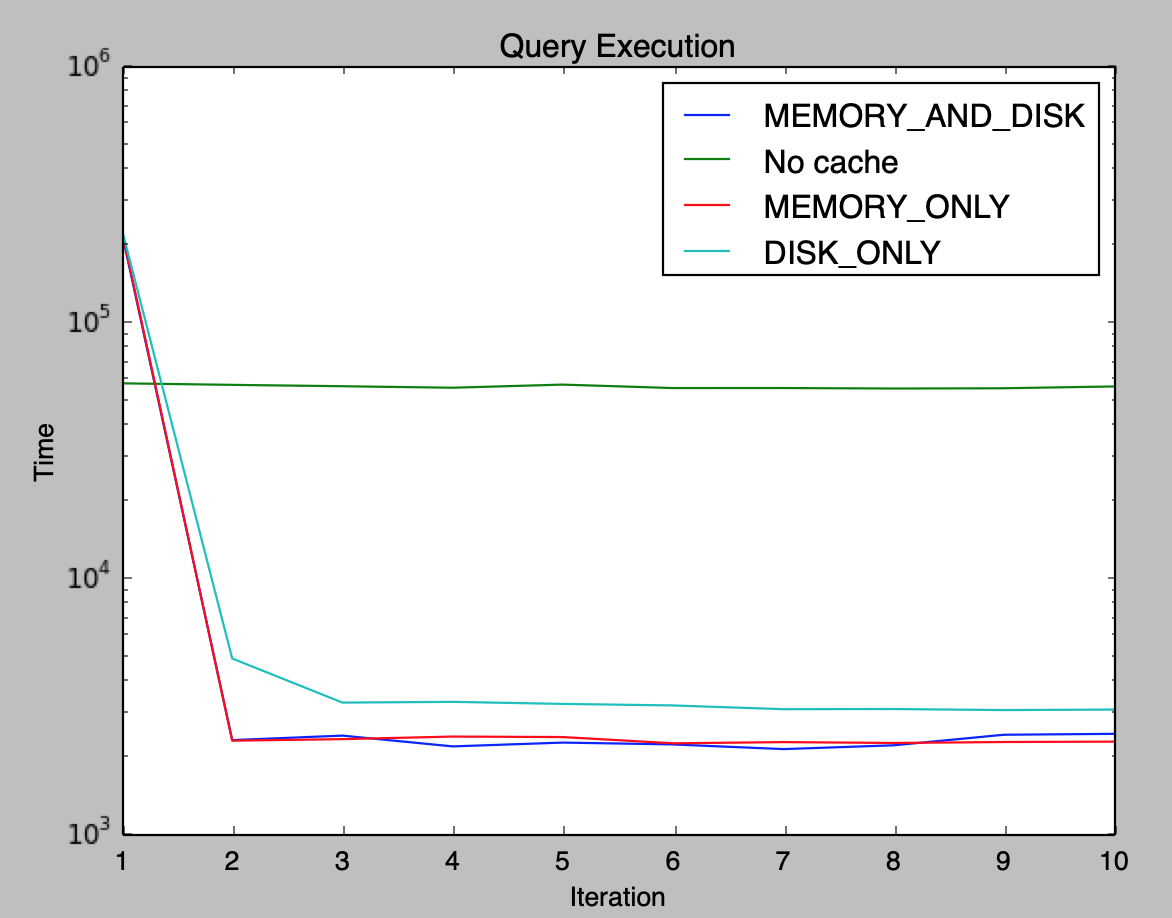

**What's the difference with persist()?**

**What's the difference with collect()?**

In [ ]:
inputFile.cache()
inputFile.show()

+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|               Email|             Address|          Avatar|Avg Session Length|       Time on App|   Time on Website|Length of Membership|Yearly Amount Spent|
+--------------------+--------------------+----------------+------------------+------------------+------------------+--------------------+-------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616|  4.0826206329529615|  587.9510539684005|
|   hduke@hotmail.com|4547 Archer Commo...|       DarkGreen| 31.92627202636016|11.109460728682564|37.268958868297744|    2.66403418213262|  392.2049334443264|
|    pallen@yahoo.com|24645 Valerie Uni...|          Bisque|33.000914755642675|11.330278057777512|37.110597442120856|   4.104543202376424| 487.54750486747207|
|riverarebecca@gma...|1414 David Throug...|   

### 📌 One-Hot Encoding: Benefits & Drawbacks

**One-hot encoding** is a classic method used to convert categorical values (like words or labels) into binary vectors. Each unique category is assigned a vector where only one element is "hot" (1), and all others are zero.

#### ✅ Benefits of One-Hot Encoding:
- **Simple and interpretable**: Easy to implement and understand.
- **Non-ordinal**: Makes no assumptions about the order or distance between categories.
- **Works well for small, fixed vocabularies**: Useful in many machine learning pipelines when the number of categories is small.

#### ⚠️ Drawbacks of One-Hot Encoding:
- **High dimensionality**: Each new category adds a new dimension → leads to sparse and memory-inefficient representations for large vocabularies.
- **No semantic similarity**: All categories are equidistant — "cat", "dog", and "banana" are all equally unrelated.
- **Not scalable for NLP**: In modern natural language processing, vocabularies can have tens or hundreds of thousands of unique tokens.
- **No generalization**: Cannot capture relationships between words like synonyms, analogies, or contextual meaning.

#### 🚀 Modern Alternative: Word Embeddings & Language Models
Today, one-hot encoding has largely been replaced in NLP by **word embeddings** (like Word2Vec, GloVe, or FastText) and especially **contextual embeddings** from **transformers and LLMs** (e.g., BERT, GPT).

These models learn **dense, low-dimensional vectors** that capture:
- Semantic similarity
- Contextual usage
- Word relationships (e.g., "king" - "man" + "woman" ≈ "queen")

While one-hot encoding still has educational value and is sometimes useful in non-text categorical data, it's **rarely used in modern NLP pipelines** — especially when large language models (LLMs) are available.

---
